In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import classification_report, confusion_matrix as conf_mat

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import numpy as np

# Download the data and unzip it
data_dir = 'nails'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'


KeyboardInterrupt: 

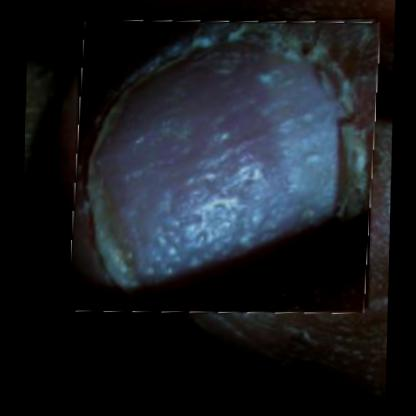

In [ ]:
from PIL import Image  # Show one example of image

Image.open('nails/train/pitting/130_JPG.rf.dccad67a78f35ba61e6ff1a6234fa14a.jpg')

In [ ]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),
    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}

# This specifies how many images to process per training
batch_size = 32

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
}

# Get the length of each dataloaders 
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')

# Preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have 117 batches of training images; each with 32 images
Single batch torch.Size([32, 3, 224, 224])


In [ ]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# See https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of ResNet50')
print(model.fc)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Defining number of hidden units in our fully connected layer
hidden_units = 1000
number_of_disease = len(class_to_idx) # Number of flower categories

# Defining the fully connected layer that will be trained on the nail images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, hidden_units)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_disease)), 
    ('output', nn.LogSoftmax(dim=1))
]))

In [ ]:
# Double check if the classifier of the model is updated.
model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  
criterion = nn.NLLLoss()  # Negative log likelihood loss
print_every = 5

training_accuracies, training_losses = [], []

best_training_loss = float("inf")
best_model_weights = None

for e in range(epochs):

    training_loss = 0.0
    training_accuracy = 0.0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Zero grad -> forward -> loss -> backward -> step
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Tracking metrics
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    # Save the best model weights so far (by training loss, since no validation set)
    if (training_loss / training_len) < best_training_loss:
        best_training_loss = training_loss / training_len
        best_model_weights = deepcopy(model.state_dict())

    print()

epoch 0 batch 0
training loss per batch 1.7958170175552368
training accuracy per batch 0.25
epoch 0 batch 5
training loss per batch 2.4000747203826904
training accuracy per batch 0.21875
epoch 0 batch 10
training loss per batch 1.893028974533081
training accuracy per batch 0.3125
epoch 0 batch 15
training loss per batch 2.0768301486968994
training accuracy per batch 0.15625
epoch 0 batch 20
training loss per batch 1.513868808746338
training accuracy per batch 0.3125
epoch 0 batch 25
training loss per batch 1.4500958919525146
training accuracy per batch 0.40625
epoch 0 batch 30
training loss per batch 1.3543939590454102
training accuracy per batch 0.46875
epoch 0 batch 35
training loss per batch 1.2363914251327515
training accuracy per batch 0.4375
epoch 0 batch 40
training loss per batch 1.2338135242462158
training accuracy per batch 0.5
epoch 0 batch 45
training loss per batch 1.2750006914138794
training accuracy per batch 0.40625
epoch 0 batch 50
training loss per batch 1.20666873455

In [ ]:
# Predict on the test data
# Load the best model so far
model.load_state_dict(best_model_weights)
test_accuracy = 0

predictions = []
label_data = []

model.eval() # Set model to evaluation mode

with torch.no_grad(): # No gradient computation for evaluation
    for images, labels in dataloaders['testing']:
        # Move to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        logits = model(images)
        
        # Predicted class indices
        preds = logits.argmax(dim=1)
        
        # Accumulate per-batch accuracy
        batch_acc = (preds == labels).float().mean().item()
        test_accuracy += batch_acc

        # Store predictions and labels for later use
        predictions.extend(preds.cpu().tolist())
        label_data.extend(labels.cpu().tolist())


In [ ]:
print(image_datasets['training'].class_to_idx)
print("\nClassification Report:")
print(classification_report(label_data, predictions, digits=4))

{'Acral_Lentiginous_Melanoma': 0, 'Healthy_Nail': 1, 'Onychogryphosis': 2, 'blue_finger': 3, 'clubbing': 4, 'pitting': 5}

Classification Report:
              precision    recall  f1-score   support

           0     0.7778    0.7778    0.7778        18
           1     1.0000    1.0000    1.0000        20
           2     0.7778    0.5833    0.6667        12
           3     0.7500    1.0000    0.8571         9
           4     1.0000    0.8125    0.8966        16
           5     0.7368    0.8750    0.8000        16

    accuracy                         0.8462        91
   macro avg     0.8404    0.8414    0.8330        91
weighted avg     0.8557    0.8462    0.8446        91



Confusion Matrix
[[14  0  0  1  0  3]
 [ 0 20  0  0  0  0]
 [ 4  0  7  1  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  1 13  2]
 [ 0  0  2  0  0 14]]



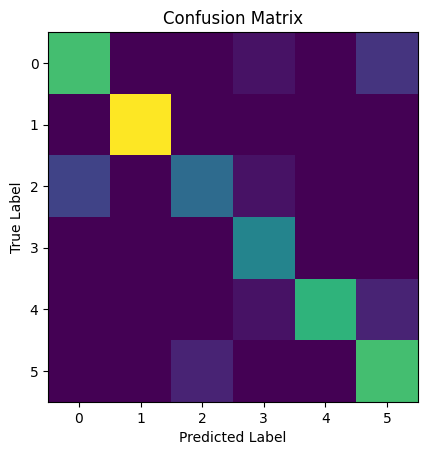

In [ ]:
cf =conf_mat(label_data, predictions)

print('Confusion Matrix')
print(cf)
print()

plt.imshow(cf)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Normalized Confusion Matrix
[[0.77777778 0.         0.         0.11111111 0.         0.1875    ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.22222222 0.         0.58333333 0.11111111 0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.11111111 0.8125     0.125     ]
 [0.         0.         0.16666667 0.         0.         0.875     ]]


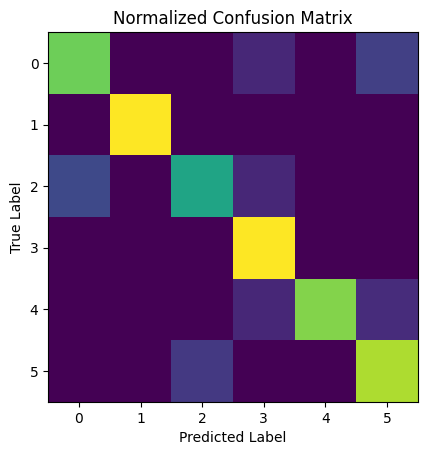

In [ ]:
# Normalized confusion matrix
print('Normalized Confusion Matrix')
ncf = cf / cf.sum(axis=1)
print(ncf)

plt.imshow(ncf)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()